In [1]:
# Parameters
DatasetID = "DS000017114"
DEV = False
test_DatasetID = ""
DS_test = False
title = "Recursion DLD1 Library1 Screen Day 5- combination of NGS 5774 and NGS 5702"
description = "Production scale screen in DLD-1 cells with 1/4 of the genome-wide CRISPR library (sub-lib-1, ~22K guides). 1 time point: Day-5. We performed 24 rxns of 10x 3' HT kit with an estimated loading of 52K cells. We performed a pilot study to test the library quality before the production-level sequencing. We will submit 72 libraries (24 GEX, 24 HTO and 24 sgRNA) We estimate need 600M for GEX, 30M for HTO and 50M for sgRNA. This is a repeat run to correct chip loading."
name_space = [{"id": "GRCh38", "type": "genome"}]
sources = [{"id": "Siavash-1234", "name": "Geo-ID"}]
tech_name = "scRNA-seq"
author = "SG"
organism = "human"
pVAL = 0.05
n = 500
embeddings_key = "X_pca"
i = 10
ED_file = "/gstore/project/crc_recursion_gw/DLD1_Sublib1_bdev//DS000017114/Energy_Distance/e_dist_all.h5ad"
key_uns = "perGene_pca_10"
out_csv = "/gstore/project/crc_recursion_gw/DLD1_Sublib1_bdev//DS000017114/Energy_Distance/e_dist_500NTCs_pca_10.csv"


# EnergyDistance: 

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
#plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from dask.distributed import Client
import sklearn

In [3]:
# Please note that if we import the whole folder using __init__.py we would be running into ba Dask CanceledError due to different 
# imported Dask conflict, so we have to import only scEnergy script
import sys
sys.path.append("..")
import Templates.tools.scEnergy as eng 

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
adata = sc.read_h5ad(ED_file)

In [6]:
adata

AnnData object with n_obs × n_vars = 595603 × 36603
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'HTO', 'NGS_ID', 'Biological_replicate', '10Xrun', 'sublibrary', 'gRNA_library_MOI', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'qc_pass', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'gem'
    var: 'Symbol'
    uns: 'DemuxAssignment_hashing_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'energy_distance', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_centered', 'X_pca_sphered', 'X_pca_sphered_Norm', 'X_scVI', 'X_scVI_centered', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
#adata.obs_names_make_unique()

## Filter adata

In [8]:
#adata = adata[adata.obs["DemuxAssignment_hashing"]!="POSITIVE_CONTROL"].copy()

In [9]:
#adata= adata[~adata.obs.index.duplicated(keep='first')].copy()

## correct gene_symbol for ENSGIDs

In [10]:
adata.obs['gene_symbol'] = adata.obs['gene_symbol'].apply(lambda x:x.split('_')[0])

## Subsampling NTCs

In [11]:
NTC = adata[adata.obs["gene_symbol"]=="NTC"].copy()

In [12]:
if n is not None:
    NTC = NTC[NTC.obs.sample(n = n).index.copy()].copy()

In [13]:
NTC

AnnData object with n_obs × n_vars = 500 × 36603
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'HTO', 'NGS_ID', 'Biological_replicate', '10Xrun', 'sublibrary', 'gRNA_library_MOI', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'qc_pass', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'gem'
    var: 'Symbol'
    uns: 'DemuxAssignment_hashing_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'energy_distance', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_centered', 'X_pca_sphered', 'X_pca_sphered_Norm', 'X_scVI', 'X_scVI_centered', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Create only genes dataframe

In [14]:
genes = [el for el in adata.obs['gene_symbol'].unique()]

In [15]:
genes.remove("NTC")

In [16]:
GENE = adata[adata.obs["gene_symbol"].isin(genes)].copy()

In [17]:
GENE

AnnData object with n_obs × n_vars = 580627 × 36603
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'HTO', 'NGS_ID', 'Biological_replicate', '10Xrun', 'sublibrary', 'gRNA_library_MOI', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'qc_pass', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'gem'
    var: 'Symbol'
    uns: 'DemuxAssignment_hashing_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'energy_distance', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_centered', 'X_pca_sphered', 'X_pca_sphered_Norm', 'X_scVI', 'X_scVI_centered', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Concatenate dataframes

In [18]:
c = NTC.concatenate(GENE)

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/anndata/_core/anndata.py:1805: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [19]:
c

AnnData object with n_obs × n_vars = 581127 × 36603
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'HTO', 'NGS_ID', 'Biological_replicate', '10Xrun', 'sublibrary', 'gRNA_library_MOI', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'qc_pass', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'gem', 'batch'
    var: 'Symbol'
    obsm: 'X_pca', 'X_pca_centered', 'X_pca_sphered', 'X_pca_sphered_Norm', 'X_scVI', 'X_scVI_centered', 'X_umap'
    layers: 'counts'

## Create dictionary with NTCs. Pool them first

### This is to calculate consistency among NTCs

In [20]:
ntcs_perturbations = [el for el in NTC.obs['DemuxAssignment_crispr'].unique()]

### Separate NTCs

In [21]:
ntcs = {}

for el in ntcs_perturbations:
    v = eng.get_values_umap(c, 'DemuxAssignment_crispr', el)
    ntcs[el] = c[v].obsm[embeddings_key]

In [22]:
pert = {}

for el in genes:
    v = eng.get_values_umap(c, 'gene_symbol', el)
    pert[el] = c[v].obsm[embeddings_key]

In [23]:
ntcs_pool = {}
W = eng.get_values_umap(c, 'gene_symbol', "NTC")
ntcs_pool['pool'] = c[W].obsm[embeddings_key]

## Run energy distance on individual NTCs to find inconsitent NTCs

In [24]:
ntc_consistency = eng.run(
    client = Client(processes=True, n_workers=32),
    perturbations = ntcs, 
    controls = ntcs_pool,
    pool = 'No'
)

In [25]:
ntc_consistency = pd.DataFrame(ntc_consistency).T

In [26]:
ntc_consistency

,pvalue,statistic,control_key
NTC_425,0.854,4.568404,pool
NTC_391,0.286,12.414624,pool
NTC_264,0.609,10.269738,pool
NTC_67,0.847,3.125065,pool
NTC_256,0.973,2.776809,pool
...,...,...,...
NTC_380,0.942,8.393447,pool
NTC_188,0.512,10.654038,pool
NTC_231,0.702,9.725308,pool
NTC_392,0.984,7.930339,pool


### Show only inconsistent NTCs with pVAL lower than the defined cut-off

In [27]:
ntc_consistency[ntc_consistency['pvalue']<=pVAL]

,pvalue,statistic,control_key
NTC_427,0.008,10.985016,pool
NTC_294,0.03,20.508817,pool
NTC_298,0.044,9.168924,pool
NTC_470,0.041,5.700583,pool
NTC_461,0.04,6.027958,pool
NTC_479,0.001,12.882296,pool
NTC_189,0.033,20.240167,pool
NTC_500,0.021,23.070485,pool
NTC_429,0.008,11.198773,pool
NTC_248,0.013,24.213059,pool


In [28]:
rm_ntcs = ntc_consistency[ntc_consistency['pvalue']<=0.01].index.tolist()
rm_ntcs

['NTC_427', 'NTC_479', 'NTC_429', 'NTC_53']

In [29]:
c.obs['rm_ntc'] = 'No'
c.obs.loc[c.obs['DemuxAssignment_crispr'].isin(rm_ntcs), 'rm_ntc'] = 'Yes'

In [30]:
c = c[c.obs['rm_ntc']=='No']
c

View of AnnData object with n_obs × n_vars = 581120 × 36603
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'HTO', 'NGS_ID', 'Biological_replicate', '10Xrun', 'sublibrary', 'gRNA_library_MOI', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'qc_pass', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'gem', 'batch', 'rm_ntc'
    var: 'Symbol'
    obsm: 'X_pca', 'X_pca_centered', 'X_pca_sphered', 'X_pca_sphered_Norm', 'X_scVI', 'X_scVI_centered', 'X_umap'
    layers: 'counts'

### Update NTCs

In [31]:
ntcs_pool = {}
W = eng.get_values_umap(c, 'gene_symbol', "NTC")
ntcs_pool['pool'] = c[W].obsm[embeddings_key]

## Calculate actual EnergyDistance as ed

In [32]:
ed = eng.run(
    client = Client(processes=True, n_workers=32),
    perturbations = pert, 
    controls = ntcs_pool,
    pool = 'Yes'
)

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33473 instead
  warnings.warn(


### Restart the client before new Computations with the refreshed client

In [33]:
#client = Client()
#client.restart()

In [34]:
PVAL = pd.DataFrame(ed).T.sort_values(by='pvalue')
PVAL

,pvalue,statistic,control_key
POLR1A,0.0,2.532549,pool
MED22,0.0,2.085382,pool
PAK1IP1,0.0,0.796605,pool
XRN1,0.0,0.78801,pool
EXOSC7,0.0,1.674282,pool
...,...,...,...
OR2M5,0.99,0.086486,pool
DVL2,0.991,0.076455,pool
HSFX3,0.994,0.143567,pool
LRRFIP1,0.994,0.088667,pool


#### p-value should be 1/1000 at minimum (for 1000 permutations)

In [35]:
PVAL['pvalue'] = PVAL['pvalue'].replace(0,0.001)

In [36]:
PVAL['gene_symbol'] = PVAL.index
PVAL.to_csv(out_csv)

### Add the energy distance info to adata

In [37]:
ed_df = pd.DataFrame(ed).T.copy()

In [38]:
ed_df['gene_symbol'] = ed_df.index
ed_df=ed_df.reset_index(drop=True)

In [39]:
ed_df['pvalue'] = ed_df['pvalue'].replace(0,0.001)

In [40]:
ed_df = ed_df.rename(columns={"pvalue":"energy_distance_pvalue","statistic":"energy_distance_statistic","control_key":"energy_distance_control_key"})

In [41]:
df_uns = adata.obs.reset_index().merge(ed_df, on="gene_symbol", how="left").set_index('index')
df_uns.index.name = None

In [42]:
b=['energy_distance_pvalue','energy_distance_statistic']#,'energy_distance_control_key','phenotype']

for el in b:
    df_uns[el] = df_uns[el].astype(float)

In [43]:
df_uns.head()

,Sample,Barcode,DemuxType_crispr,DemuxAssignment_crispr,DemuxType_hashing,DemuxAssignment_hashing,cellline,timepoint,HTO,NGS_ID,...,pct_counts_ribo,qc_pass,S_score,G2M_score,phase,SCN_class,gem,energy_distance_pvalue,energy_distance_statistic,energy_distance_control_key
SAM24451293_rep1-AAACCCAAGAAATCCA,SAM24451293,AAACCCAAGAAATCCA,singlet,ENSG00000154124_2,singlet,SAM24439044,DLD1,day5,HTO-14,NGS5774,...,19.529837,True,-0.734884,-0.491440,G1,Untreatedclus_DLD1,NGS5774-1,0.312,0.122883,pool
SAM24451293_rep1-AAACCCAAGACAGTCG,SAM24451293,AAACCCAAGACAGTCG,singlet,ENSG00000171017_3,singlet,SAM24439045,DLD1,day5,HTO-18,NGS5774,...,22.065006,True,-0.493023,0.231481,G2M,Untreatedclus_DLD1,NGS5774-1,0.025,0.202001,pool
SAM24451293_rep1-AAACCCACAGACCCGT,SAM24451293,AAACCCACAGACCCGT,singlet,ENSG00000140057_1,singlet,SAM24439043,DLD1,day5,HTO-10,NGS5774,...,14.875622,True,-0.158140,-0.564640,G1,Untreatedclus_DLD1,NGS5774-1,0.551,0.106587,pool
SAM24451293_rep1-AAACCCAGTAACGATA,SAM24451293,AAACCCAGTAACGATA,singlet,ENSG00000188611_3,singlet,POSITIVE_CONTROL,DLD1,day5,HTO-19,NGS5774,...,25.018056,True,-0.520930,-0.385045,G1,Untreatedclus_DLD1,NGS5774-1,0.670,0.088444,pool
SAM24451293_rep1-AAACCCAGTACGACAG,SAM24451293,AAACCCAGTACGACAG,singlet,ENSG00000166664_2,singlet,SAM24439043,DLD1,day5,HTO-1,NGS5774,...,17.613996,True,0.334884,-0.072851,S,Untreatedclus_DLD1,NGS5774-1,0.221,0.111543,pool


In [44]:
#df_uns.index = df_uns.index.astype(str)

In [45]:
df_uns = df_uns.drop(columns='energy_distance_control_key')

In [46]:
df_uns['phenotype'] = 'No'
df_uns.loc[df_uns['energy_distance_pvalue']<=pVAL, 'phenotype'] = 'Yes'

In [47]:
PHENO = df_uns[df_uns['phenotype']=='Yes'].copy()
PHENO['gene_symbol'].nunique()

1285

## Update the annadata object and write out the output

In [48]:
df_uns_ED = df_uns[['energy_distance_pvalue','energy_distance_statistic','phenotype']].copy()
df_uns_ED = df_uns_ED.rename(columns={'phenotype': 'phenotype_@0.05'})

In [49]:
if 'energy_distance' not in adata.uns:
    adata.uns["energy_distance"]={}

In [50]:
adata.uns["energy_distance"][key_uns]=df_uns_ED

In [51]:
adata.write(ED_file)

## Data Tabulation

In [52]:
df_uns.groupby(['SCN_class', 'phenotype'])['gene_symbol'].size()

SCN_class             phenotype
DOXclus_CL34          No              131
                      Yes              58
DOXclus_DLD1          No            46261
                      Yes           17555
DOXclus_HCA7          No               12
                      Yes               7
DOXclus_HT55          No                1
                      Yes               0
DOXclus_MDST8         No               57
                      Yes              29
DOXclus_SW480         No                2
                      Yes               1
DOXclus_SW620         No                1
                      Yes               0
DOXclus_SW1463        No              671
                      Yes             326
Untreatedclus_CL34    No                7
                      Yes               1
Untreatedclus_DLD1    No           409334
                      Yes          117967
Untreatedclus_HT55    No                1
                      Yes               0
Untreatedclus_RCM1    No             1059
  

In [53]:
df_uns[(df_uns['phenotype']=='Yes')&(df_uns['SCN_class']=='DOXclus_DLD1')].groupby(
    ['gene_symbol'])['DemuxAssignment_crispr'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)

,gene_symbol,cnt
1099,TCF7L2,118
214,CTNNB1,78
651,MYC,65
670,NELFB,47
1207,UBTF,43
...,...,...
912,RGPD5,1
1027,SNIP1,1
209,CSNK1A1,1
268,ECD,1


In [54]:
df_uns[(df_uns['phenotype']=='Yes')&(df_uns['SCN_class']=='Untreatedclus_DLD1')].groupby(
    ['gene_symbol'])['DemuxAssignment_crispr'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)

,gene_symbol,cnt
1103,TCF7L2,362
38,AOC3,188
495,IL15,162
348,F11R,161
436,GSTK1,154
...,...,...
814,POLR2B,7
856,PSMA6,7
803,PLK1,6
914,RGPD5,4


In [55]:
df_uns[(df_uns['phenotype']=='Yes')].groupby(
    ['gene_symbol'])['DemuxAssignment_crispr'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)[:30]

,gene_symbol,cnt
1103,TCF7L2,484
38,AOC3,217
495,IL15,177
962,RUNX2,173
466,HP1BP3,172
436,GSTK1,172
439,GTF2H5,172
812,POLK,170
348,F11R,170
809,PNPO,168


## Data Visulaization

<AxesSubplot: xlabel='energy_distance_pvalue', ylabel='Count'>

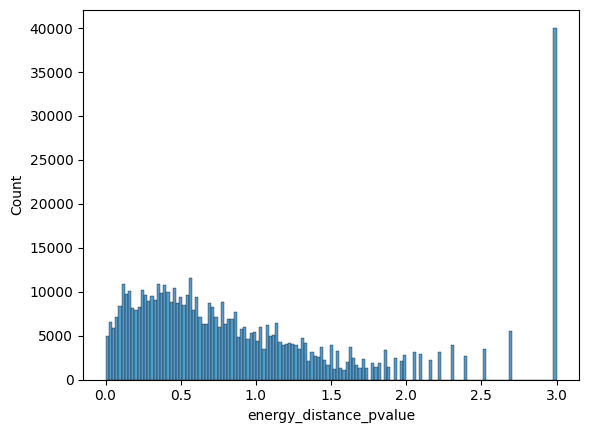

In [56]:
sns.histplot(-np.log10(df_uns['energy_distance_pvalue']))